## In this notebook the traiend prototype wgans are validating/evaluated against the heldout and evaluation dataset to assess performance over differing cell lines and seeding densities

In [1]:
import pathlib
import sys
import yaml

import pandas as pd
import torch
from torch.utils.data import DataLoader
import mlflow
import mlflow.artifacts
import lpips
from DISTS_pytorch import DISTS
import seaborn as sns
import matplotlib.pyplot as plt

## Read config

In [2]:
with open(pathlib.Path('.').absolute().parent.parent / "config.yml", "r") as file:
    config = yaml.safe_load(file)

## Import virtual_stain_flow software 

In [3]:
sys.path.append(config['paths']['software_path'])
print(str(pathlib.Path('.').absolute().parent.parent))

## Dataset
from virtual_stain_flow.datasets.PatchDataset import PatchDataset
from virtual_stain_flow.datasets.CachedDataset import CachedDataset

## FNet training
from virtual_stain_flow.models.fnet import FNet
from virtual_stain_flow.trainers.Trainer import Trainer

## wGaN training
from virtual_stain_flow.models.unet import UNet
from virtual_stain_flow.models.discriminator import GlobalDiscriminator
from virtual_stain_flow.trainers.WGaNTrainer import WGaNTrainer

## wGaN losses
from virtual_stain_flow.losses.GradientPenaltyLoss import GradientPenaltyLoss
from virtual_stain_flow.losses.DiscriminatorLoss import DiscriminatorLoss
from virtual_stain_flow.losses.GeneratorLoss import GeneratorLoss

from virtual_stain_flow.transforms.MinMaxNormalize import MinMaxNormalize
from virtual_stain_flow.transforms.PixelDepthTransform import PixelDepthTransform

## Metrics
from virtual_stain_flow.metrics.MetricsWrapper import MetricsWrapper
from virtual_stain_flow.metrics.PSNR import PSNR
from virtual_stain_flow.metrics.SSIM import SSIM

## callback
from virtual_stain_flow.callbacks.MlflowLogger import MlflowLogger
from virtual_stain_flow.callbacks.IntermediatePlot import IntermediatePatchPlot

/home/weishanli/Waylab/pediatric_cancer_atlas_analysis


/home/weishanli/anaconda3/envs/alsf_iqa/lib/python3.11/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.1'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
from virtual_stain_flow.evaluation.plot_utils import plot_patches
from virtual_stain_flow.evaluation.evaluation_utils import evaluate_per_image_metric
from virtual_stain_flow.evaluation.predict_utils import predict_image

## Define paths and other train parameters

In [5]:
## Loaddata for train and heldout set
LOADDATA_FILE_PATH = pathlib.Path('.').absolute().parent.parent \
    / '0.data_preprocessing' / 'data_split_loaddata' / 'loaddata_train.csv'
assert LOADDATA_FILE_PATH.exists()
LOADDATA_HELDOUT_FILE_PATH = pathlib.Path('.').absolute().parent.parent \
    / '0.data_preprocessing' / 'data_split_loaddata' / 'loaddata_heldout.csv'
assert LOADDATA_HELDOUT_FILE_PATH.exists()
LOADDATA_EVAL_FILE_PATH = pathlib.Path('.').absolute().parent.parent \
    / '0.data_preprocessing' / 'data_split_loaddata' / 'loaddata_eval.csv'
assert LOADDATA_EVAL_FILE_PATH.exists()

## Corresponding sc features directory containing cell coordiantes used for patch generation
SC_FEATURES_DIR = pathlib.Path(config['paths']['sc_features_path'])
assert SC_FEATURES_DIR.exists()

## Optimization Output Saved under these directories
MLFLOW_DIR = pathlib.Path('.').absolute() / 'mlflow'
assert MLFLOW_DIR.exists()
mlflow.set_tracking_uri(MLFLOW_DIR / 'mlruns')

## Define and create Evaluation result save path
EVALUATION_DIR = pathlib.Path('.').absolute() / 'evaluation'
EVALUATION_DIR.mkdir(exist_ok=True)
EVALUATION_INTERMEDIATE_DIR = EVALUATION_DIR / 'intermediate'
EVALUATION_INTERMEDIATE_DIR.mkdir(exist_ok=True)
EVALUATION_PLOTS_DIR = EVALUATION_DIR / 'plots'
EVALUATION_PLOTS_DIR.mkdir(exist_ok=True)
# Define the path for the master metrics file
ALL_METRICS_FILE = EVALUATION_DIR / "all_metrics.csv"

## Channels for input and target are read from config
INPUT_CHANNEL_NAMES = config['data']['input_channel_keys']
TARGET_CHANNEL_NAMES = config['data']['target_channel_keys']

In [6]:
## Patch size definition
PATCH_SIZE = 256
CONFLUENCE_GROUPS = ['high_confluence', 'low_confluence']

In [7]:
# metric_fns = {
#         "mse_loss": MetricsWrapper(_metric_name='mse', module=torch.nn.MSELoss()),
#         "ssim_loss": SSIM(_metric_name="ssim"),
#         "psnr_loss": PSNR(_metric_name="psnr"),
#         "lpips": lpips.LPIPS(net='vgg'),
#         "dists": DISTS()
#     }

## Define Discrete Conditions to Evaluate

In [8]:
# Relevant columns in loaddata
SITE_COLUMN = 'Metadata_Site'
WELL_COLUMN = 'Metadata_Well'
PLATE_COLUMN = 'Metadata_Plate'

PLATEMAP_COLUMN = 'platemap_file'
CELL_LINE_COLUMN = 'cell_line'
SEEDING_DENSITY_COLUMN = 'seeding_density'

# Sites are uniquely identified by the combination of these columns
UNIQUE_IDENTIFIERS = [SITE_COLUMN, WELL_COLUMN, PLATE_COLUMN]
# Conditions are uniquely identified by the combination of these columns
CONDITION_IDENTIFIERS =  [CELL_LINE_COLUMN, SEEDING_DENSITY_COLUMN, PLATEMAP_COLUMN]

## Concatenate datasplits into a single dataframe to streamline evaluation

In [9]:
## Concat all datasplits
loaddata_df_all = pd.DataFrame()
for datasplit, file in zip(
    ['train', 'heldout', 'evaluation'], 
    [LOADDATA_FILE_PATH, LOADDATA_HELDOUT_FILE_PATH, LOADDATA_EVAL_FILE_PATH]):
    loaddata_df = pd.read_csv(file, index_col=0)
    loaddata_df['datasplit'] = datasplit
    loaddata_df_all = pd.concat([loaddata_df_all, loaddata_df])
loaddata_df_all.head()

,Metadata_Plate,time_point,platemap_file,cell_line,row,column,Metadata_Well,seeding_density,FileName_OrigBrightfield,PathName_OrigBrightfield,...,Metadata_ChannelID,Metadata_Col,Metadata_FieldID,Metadata_PlaneID,Metadata_PositionX,Metadata_PositionY,Metadata_PositionZ,Metadata_Row,Metadata_Reimaged,datasplit
0,BR00143976,24,Assay_Plate1_platemap,U2-OS,M,13,M13,1000,r13c13f01p01-ch1sk1fk1fl1.tiff,/home/weishanli/Waylab/ALSF_pilot/data/ALSF_pi...,...,6.0,13.0,1.0,1.0,0.000000,0.000000,-0.000006,13.0,False,train
1,BR00143976,24,Assay_Plate1_platemap,U2-OS,M,13,M13,1000,r13c13f02p01-ch1sk1fk1fl1.tiff,/home/weishanli/Waylab/ALSF_pilot/data/ALSF_pi...,...,6.0,13.0,2.0,1.0,-0.000646,0.000646,-0.000006,13.0,False,train
2,BR00143976,24,Assay_Plate1_platemap,U2-OS,M,13,M13,1000,r13c13f03p01-ch1sk1fk1fl1.tiff,/home/weishanli/Waylab/ALSF_pilot/data/ALSF_pi...,...,6.0,13.0,3.0,1.0,0.000000,0.000646,-0.000006,13.0,False,train
3,BR00143976,24,Assay_Plate1_platemap,U2-OS,M,13,M13,1000,r13c13f04p01-ch1sk1fk1fl1.tiff,/home/weishanli/Waylab/ALSF_pilot/data/ALSF_pi...,...,6.0,13.0,4.0,1.0,0.000646,0.000646,-0.000006,13.0,False,train
4,BR00143976,24,Assay_Plate1_platemap,U2-OS,M,13,M13,1000,r13c13f05p01-ch1sk1fk1fl1.tiff,/home/weishanli/Waylab/ALSF_pilot/data/ALSF_pi...,...,6.0,13.0,5.0,1.0,0.000646,0.000000,-0.000006,13.0,False,train


## Concatenate mlflow runs across confluence group trainings to streamline evaluation

In [10]:
mlflow_runs = pd.DataFrame()
for confluence_group in CONFLUENCE_GROUPS:
    experiment_name = f'wGAN_gp_prototype_train_{confluence_group}'
    experiment = mlflow.get_experiment_by_name(experiment_name)
    mlflow_runs = pd.concat(
        [mlflow_runs, mlflow.search_runs(experiment_ids=[experiment.experiment_id])]
         )
mlflow_runs['params.confluence'] = mlflow_runs['tags.mlflow.runName'].str.extract(r'wGAN_gp_prototype_train_(.+?)_confluence_.+')
mlflow_runs['params.channel_name'] = mlflow_runs['tags.mlflow.runName'].str.extract(r'wGAN_gp_prototype_train_.+?_confluence_(.+)')
mlflow_runs.head()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.DiscriminatorLoss,metrics.val_mse_loss,metrics.epoch,metrics.val_DiscriminatorLoss,...,params.gp_loss_weight,params.gen_optim_lr,params.disc_depth,params.gen_optim_beta0,tags.mlflow.source.type,tags.mlflow.runName,tags.mlflow.user,tags.mlflow.source.name,params.confluence,params.channel_name
0,60b4d245d0d342ccb4f4d6cc8814c558,554784804104899423,FINISHED,file:///home/weishanli/Waylab/pediatric_cancer...,2025-02-26 22:06:41.012000+00:00,2025-02-26 22:20:18.928000+00:00,-0.000086,0.000811,32.0,5.575556e-04,...,10.0,0.0002,4,0.0,LOCAL,wGAN_gp_prototype_train_high_confluence_OrigRNA,weishanli,/home/weishanli/anaconda3/envs/speckle_analysi...,high,OrigRNA
1,fb1522213c0a4cef8d69f30d2c94ec59,554784804104899423,FINISHED,file:///home/weishanli/Waylab/pediatric_cancer...,2025-02-26 21:50:56.690000+00:00,2025-02-26 22:06:38.392000+00:00,0.066461,0.013385,37.0,-4.818013e-02,...,10.0,0.0002,4,0.0,LOCAL,wGAN_gp_prototype_train_high_confluence_OrigMito,weishanli,/home/weishanli/anaconda3/envs/speckle_analysi...,high,OrigMito
2,5079faeff16640b7aba39ef27c029987,554784804104899423,FINISHED,file:///home/weishanli/Waylab/pediatric_cancer...,2025-02-26 21:38:59.684000+00:00,2025-02-26 21:50:54.119000+00:00,0.000026,0.000027,28.0,-8.263496e-05,...,10.0,0.0002,4,0.0,LOCAL,wGAN_gp_prototype_train_high_confluence_OrigAGP,weishanli,/home/weishanli/anaconda3/envs/speckle_analysi...,high,OrigAGP
3,aa89673f694544a79dc59e1a8634ddfe,554784804104899423,FINISHED,file:///home/weishanli/Waylab/pediatric_cancer...,2025-02-26 21:26:04.581000+00:00,2025-02-26 21:38:56.292000+00:00,-0.025819,0.001665,30.0,5.402019e-03,...,10.0,0.0002,4,0.0,LOCAL,wGAN_gp_prototype_train_high_confluence_OrigER,weishanli,/home/weishanli/anaconda3/envs/speckle_analysi...,high,OrigER
4,5347165d13704b328978617334e6c16d,554784804104899423,FINISHED,file:///home/weishanli/Waylab/pediatric_cancer...,2025-02-26 21:13:40.059000+00:00,2025-02-26 21:26:02.030000+00:00,0.022790,0.001204,27.0,-8.264227e-11,...,10.0,0.0002,4,0.0,LOCAL,wGAN_gp_prototype_train_high_confluence_OrigDNA,weishanli,/home/weishanli/anaconda3/envs/speckle_analysi...,high,OrigDNA


## Define Device to be used with evaluation and metrics to be computed

In [11]:
EVAL_DEVICE = 'cuda'
EVAL_METRICS = [
    PSNR(_metric_name='psnr'), 
    SSIM(_metric_name='ssim'), 
    torch.nn.MSELoss(), 
    torch.nn.L1Loss(),
    lpips.LPIPS(net='vgg'),
    DISTS()
    ]

/home/weishanli/anaconda3/envs/alsf_iqa/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/weishanli/anaconda3/envs/alsf_iqa/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/weishanli/anaconda3/envs/alsf_iqa/lib/python3.11/site-packages/lpips/weights/v0.1/vgg.pth


/home/weishanli/anaconda3/envs/alsf_iqa/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_

In [12]:
# Load existing metrics if the file exists
if ALL_METRICS_FILE.exists():
    all_metrics_df = pd.read_csv(ALL_METRICS_FILE, dtype=str)
else:
    all_metrics_df = pd.DataFrame()

for conditions, loaddata_condition_df in loaddata_df_all.groupby(CONDITION_IDENTIFIERS + ['datasplit']):
    
    datasplit = conditions[-1]
    condition_dict = {condition_column_name: condition \
                      for condition_column_name, condition in \
                        zip(CONDITION_IDENTIFIERS, conditions[:-1])}
    
    condition_str = ';'.join([f"{key.replace('params.','')}={value}" for key, value in condition_dict.items()])
    print(f"Evaluating {condition_str}")

    # Check if the condition has already been evaluated
    existing_conditions = all_metrics_df.query(
        " & ".join([f"{key} == '{value}'" for key, value in condition_dict.items()])
    ) if not all_metrics_df.empty else pd.DataFrame()

    sc_features = pd.DataFrame()
    for plate in loaddata_condition_df[PLATE_COLUMN].unique():
        sc_features_parquet = SC_FEATURES_DIR / f'{plate}_sc_normalized.parquet'
        if not sc_features_parquet.exists():
            print(f'{sc_features_parquet} does not exist, skipping...')
            continue 
        else:
            sc_features = pd.concat([
                sc_features, 
                pd.read_parquet(
                    sc_features_parquet,
                    columns=UNIQUE_IDENTIFIERS + ['Metadata_Cells_Location_Center_X', 'Metadata_Cells_Location_Center_Y']
                )
            ])

    pds = PatchDataset(
        _loaddata_csv=loaddata_condition_df,
        _sc_feature=sc_features,
        _input_channel_keys=INPUT_CHANNEL_NAMES,
        _target_channel_keys=TARGET_CHANNEL_NAMES,
        _input_transform=PixelDepthTransform(src_bit_depth=16, target_bit_depth=8, _always_apply=True),
        _target_transform=MinMaxNormalize(_normalization_factor=(2 ** 16) - 1, _always_apply=True),
        patch_size=PATCH_SIZE,
        verbose=False,
        patch_generation_method="random_cell",
        n_expected_patches_per_img=50,
        patch_generation_random_seed=42
    )

    for target_channel_name, channel_mlflow_runs in mlflow_runs.groupby('params.channel_name'):

        pds.set_input_channel_keys(INPUT_CHANNEL_NAMES)
        pds.set_target_channel_keys([target_channel_name])
        _, targets = next(iter(DataLoader(pds, batch_size=len(pds))))

        for _, run in channel_mlflow_runs.iterrows():
            
            run_id = run['run_id']
            run_name = run['tags.mlflow.runName']

            # Check if this model has already been evaluated for this condition
            if not existing_conditions.empty and run_id in existing_conditions['run_id'].values:
                print(f"Skipping evaluation for run {run_id} (already exists in master file)")
                continue

            model_uri = run['artifact_uri']
            model_weight_path = pathlib.Path(mlflow.artifacts.download_artifacts(artifact_uri=model_uri)) /\
                            'models' / 'best_model_weights.pth'
            if not model_weight_path.exists():
                print(f"Model weight not found for run {run_name}, skipping ...")
                continue

            model_depth = int(run['params.gen_depth'])
            model = UNet(
                n_channels=1,
                n_classes=1,
                depth=model_depth,
                bilinear=False
            )
            try:
                model.load_state_dict(torch.load(model_weight_path, weights_only=True))
            except:
                print(f"Fail to load model weight for run {run_id}, skipping ...")
                continue
            model.to(EVAL_DEVICE)

            predictions, _ = predict_image(
                dataset=pds,
                model=model,
                device=EVAL_DEVICE
            )

            metrics_df = evaluate_per_image_metric(
                predictions=predictions,
                targets=targets,
                metrics=EVAL_METRICS
            )

            metrics_df['datasplit'] = datasplit
            for condition_name, value in condition_dict.items():
                metrics_df[condition_name] = value
            metrics_df['run_name'] = run_name
            metrics_df['run_id'] = run_id
            for param_name, value in run.items():
                if param_name.startswith('params.'):
                    metrics_df[param_name] = value
            
            ### Ensure Column Consistency Before Appending ###
            # If master file exists and has columns, ensure column match
            if not all_metrics_df.empty:
                # Add missing columns to metrics_df
                for col in all_metrics_df.columns:
                    if col not in metrics_df.columns:
                        metrics_df[col] = None  # Fill missing columns with NaN
                
                # Add new columns from metrics_df to all_metrics_df
                for col in metrics_df.columns:
                    if col not in all_metrics_df.columns:
                        all_metrics_df[col] = None  # Fill missing columns with NaN

                # Reorder metrics_df to match all_metrics_df column order
                metrics_df = metrics_df[all_metrics_df.columns]

            metrics_df.to_csv(EVALUATION_INTERMEDIATE_DIR / f'{run_name}_{condition_str}.csv', index=False)
            # Append new results to the master file
            metrics_df.to_csv(ALL_METRICS_FILE, mode='a', header=not ALL_METRICS_FILE.exists(), index=False)

            # Plot 5 random patches
            plot_patches(
                dataset=pds,
                n_patches=5,
                model=model,
                random_seed=42,
                device=EVAL_DEVICE,
                metrics=EVAL_METRICS,
                show_plot=False,
                save_path=EVALUATION_PLOTS_DIR / f'{run_name}_{condition_str}.png'
            )

Evaluating cell_line=A673;seeding_density=1000;platemap_file=Assay_Plate1_platemap
Skipping evaluation for run 5079faeff16640b7aba39ef27c029987 (already exists in master file)
Skipping evaluation for run 12c3e4d225c4457eba03f4b333877412 (already exists in master file)
Skipping evaluation for run 5347165d13704b328978617334e6c16d (already exists in master file)
Skipping evaluation for run 3f746e5902c548b19158bb45040560b5 (already exists in master file)
Skipping evaluation for run aa89673f694544a79dc59e1a8634ddfe (already exists in master file)
Skipping evaluation for run f7bcd8ce80b146c1801044aef2ba4519 (already exists in master file)
Skipping evaluation for run fb1522213c0a4cef8d69f30d2c94ec59 (already exists in master file)
Skipping evaluation for run 55f17dcacd93429bae00ff0459ac4705 (already exists in master file)
Skipping evaluation for run 60b4d245d0d342ccb4f4d6cc8814c558 (already exists in master file)
Skipping evaluation for run 8bf5072db4534b85b3e42a0d8488fa23 (already exists in 

## Visualize Performance Across Conditions

In [13]:
all_metrics_df = pd.read_csv(ALL_METRICS_FILE)
all_metrics_df['confluence_group'] = all_metrics_df['run_name'].str.extract(r'wGAN_gp_prototype_train_(.+?)_confluence_.+')
all_metrics_df.head()

,PSNR,SSIM,MSELoss,L1Loss,LPIPS,DISTS,datasplit,cell_line,seeding_density,platemap_file,...,params.gen_depth,params.gen_optim_beta0,params.disc_optim_weight_decay,params.gen_optim_weight_decay,params.gp_loss_weight,params.gen_optim_beta1,params.gen_update_freq,params.confluence,params.channel_name,confluence_group
0,40.202316,0.594707,0.000095,0.008643,0.030524,0.251278,evaluation,A673,1000,Assay_Plate1_platemap,...,4,0.0,0.001,0,10.0,0.9,5,high,OrigAGP,high
1,33.256210,0.333096,0.000472,0.011995,0.074666,0.288461,evaluation,A673,1000,Assay_Plate1_platemap,...,4,0.0,0.001,0,10.0,0.9,5,high,OrigAGP,high
2,37.051292,0.484929,0.000197,0.010136,0.018950,0.225079,evaluation,A673,1000,Assay_Plate1_platemap,...,4,0.0,0.001,0,10.0,0.9,5,high,OrigAGP,high
3,39.599640,0.524679,0.000110,0.010241,0.024285,0.195178,evaluation,A673,1000,Assay_Plate1_platemap,...,4,0.0,0.001,0,10.0,0.9,5,high,OrigAGP,high
4,37.275726,0.498827,0.000187,0.009823,0.022561,0.227211,evaluation,A673,1000,Assay_Plate1_platemap,...,4,0.0,0.001,0,10.0,0.9,5,high,OrigAGP,high


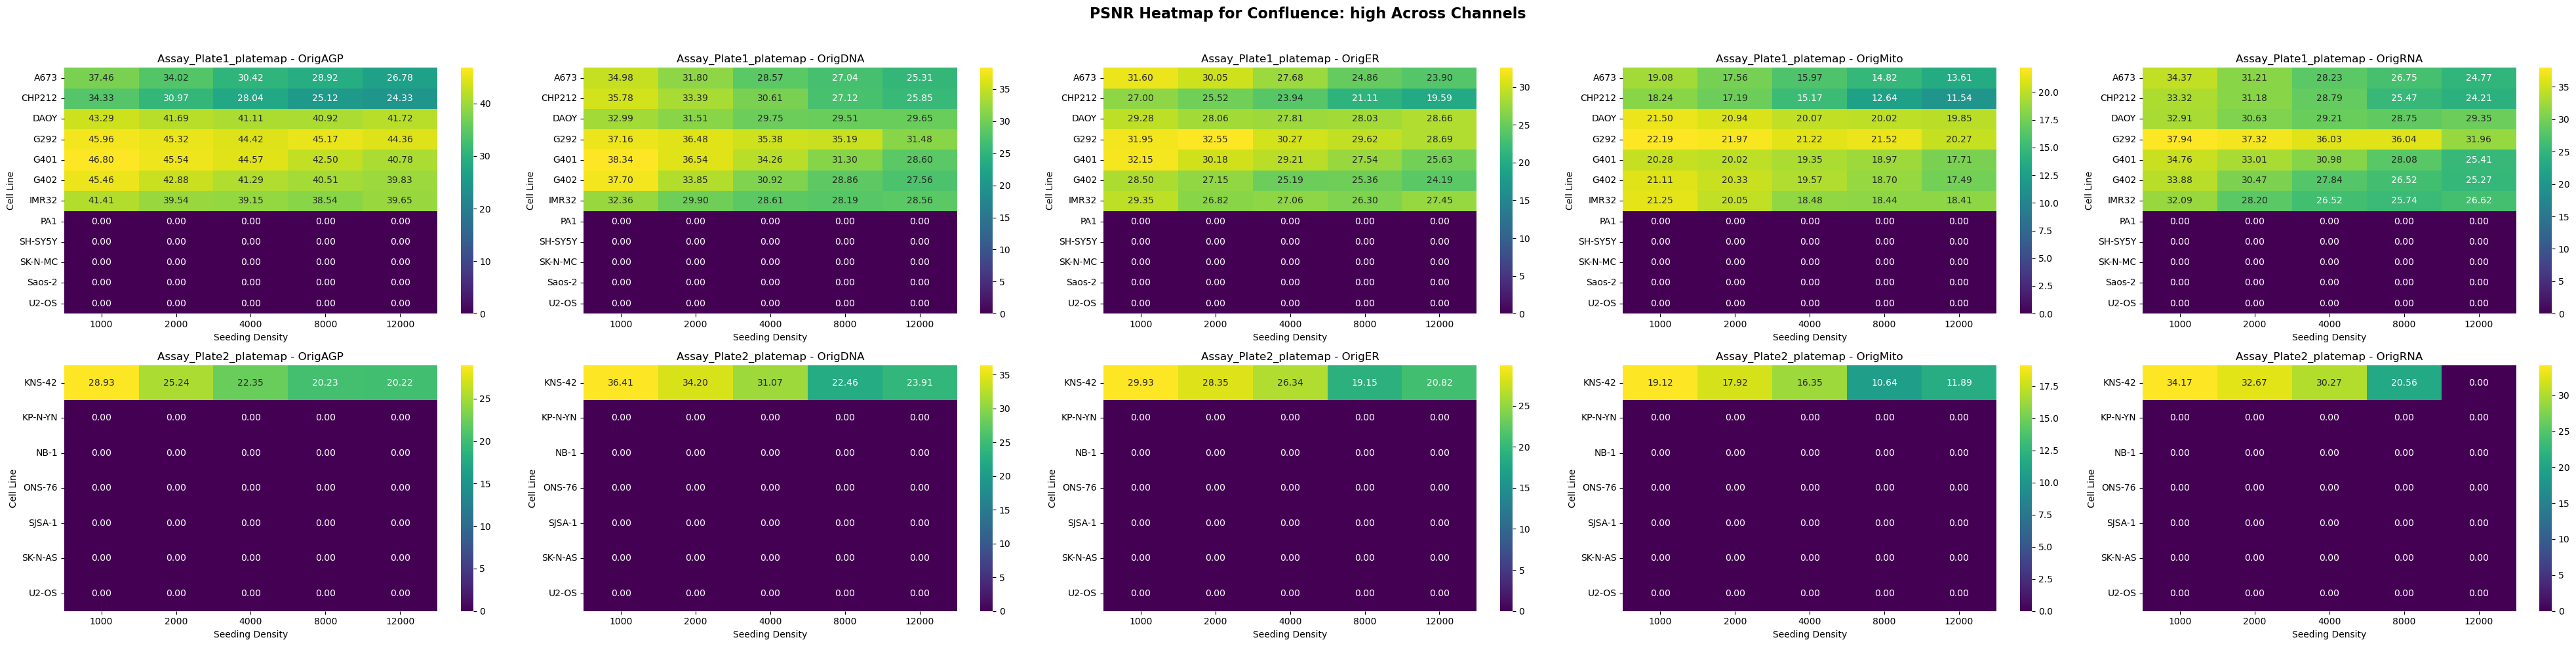

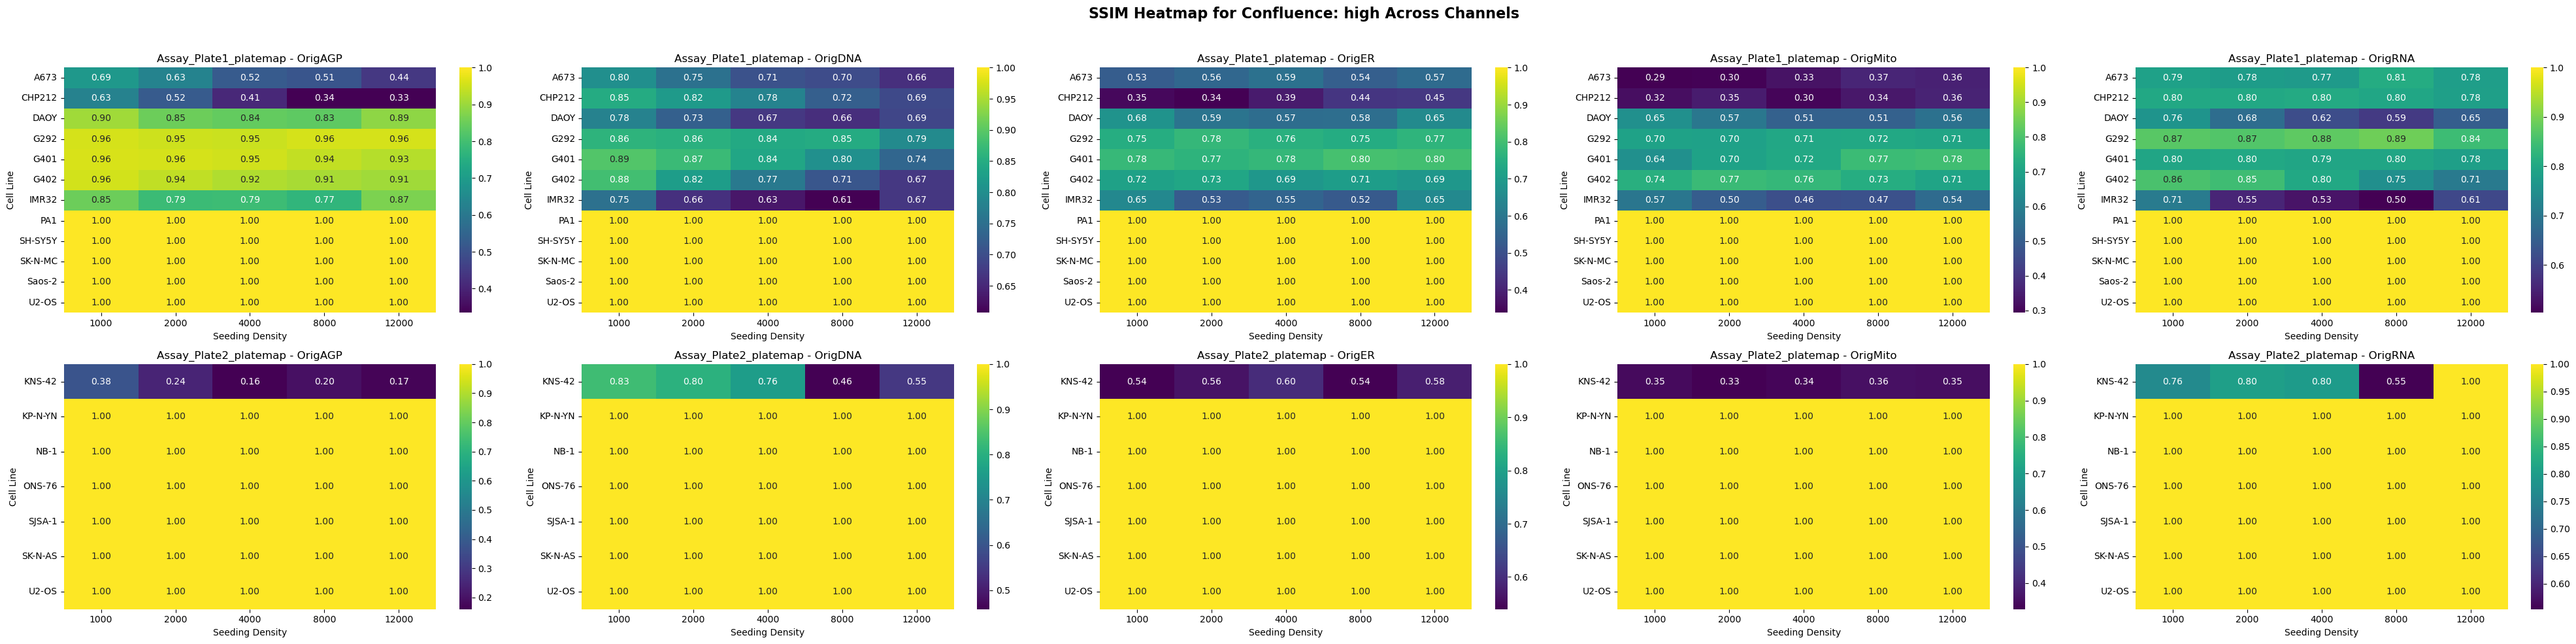

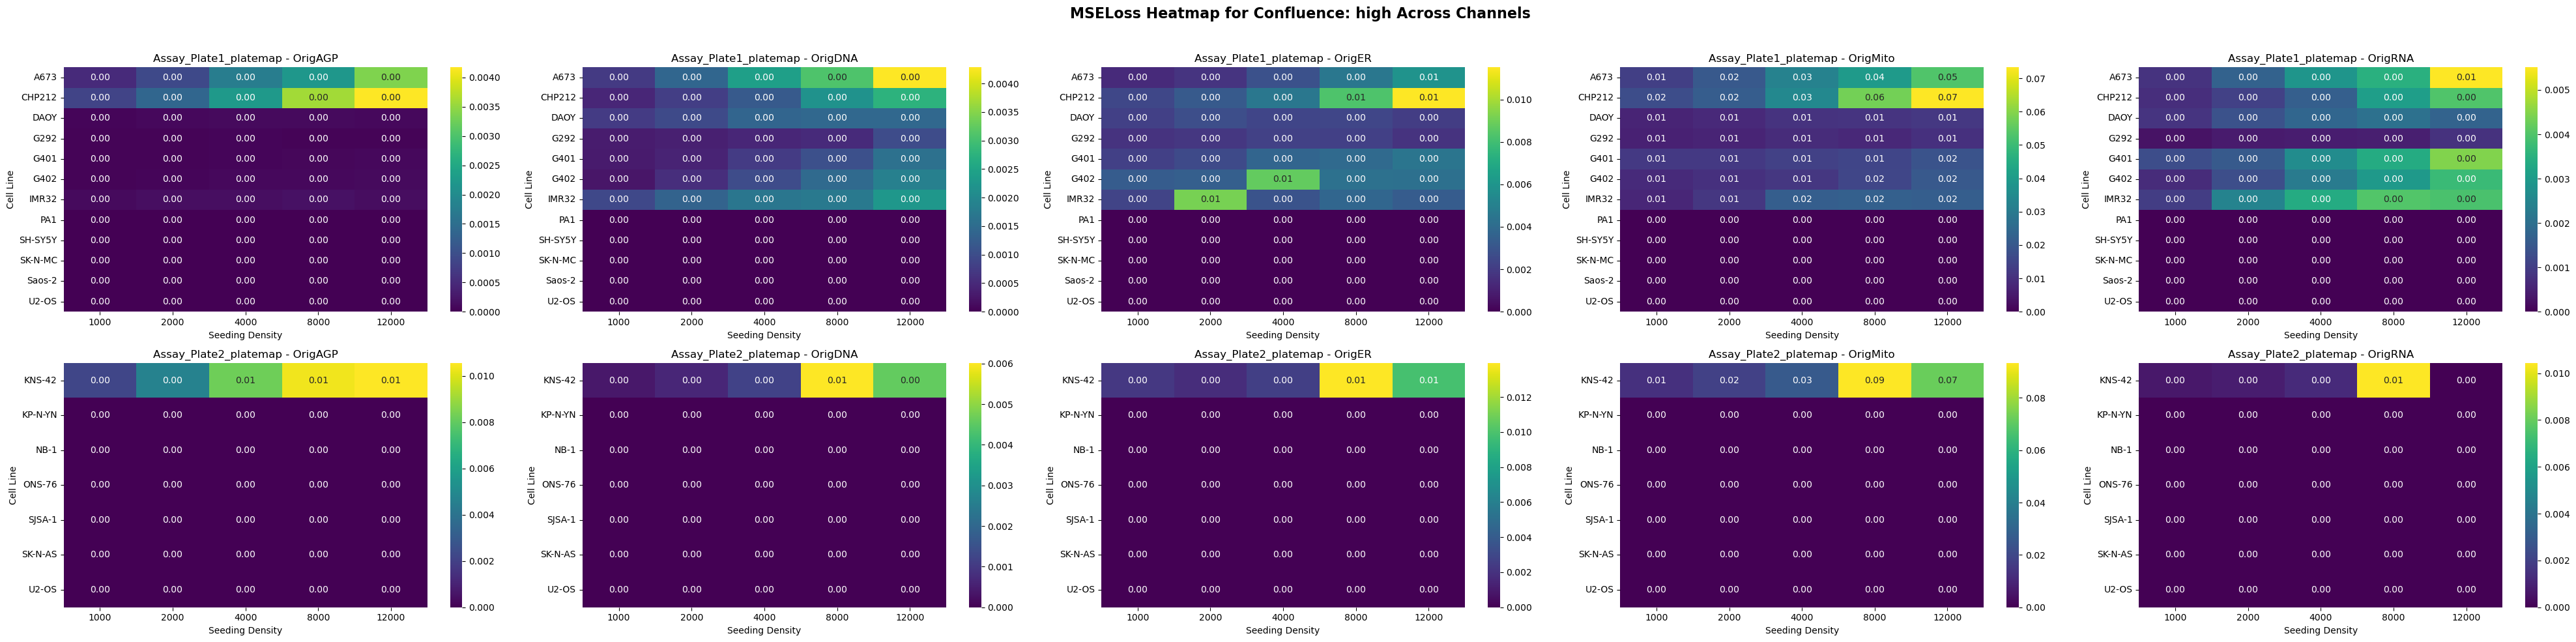

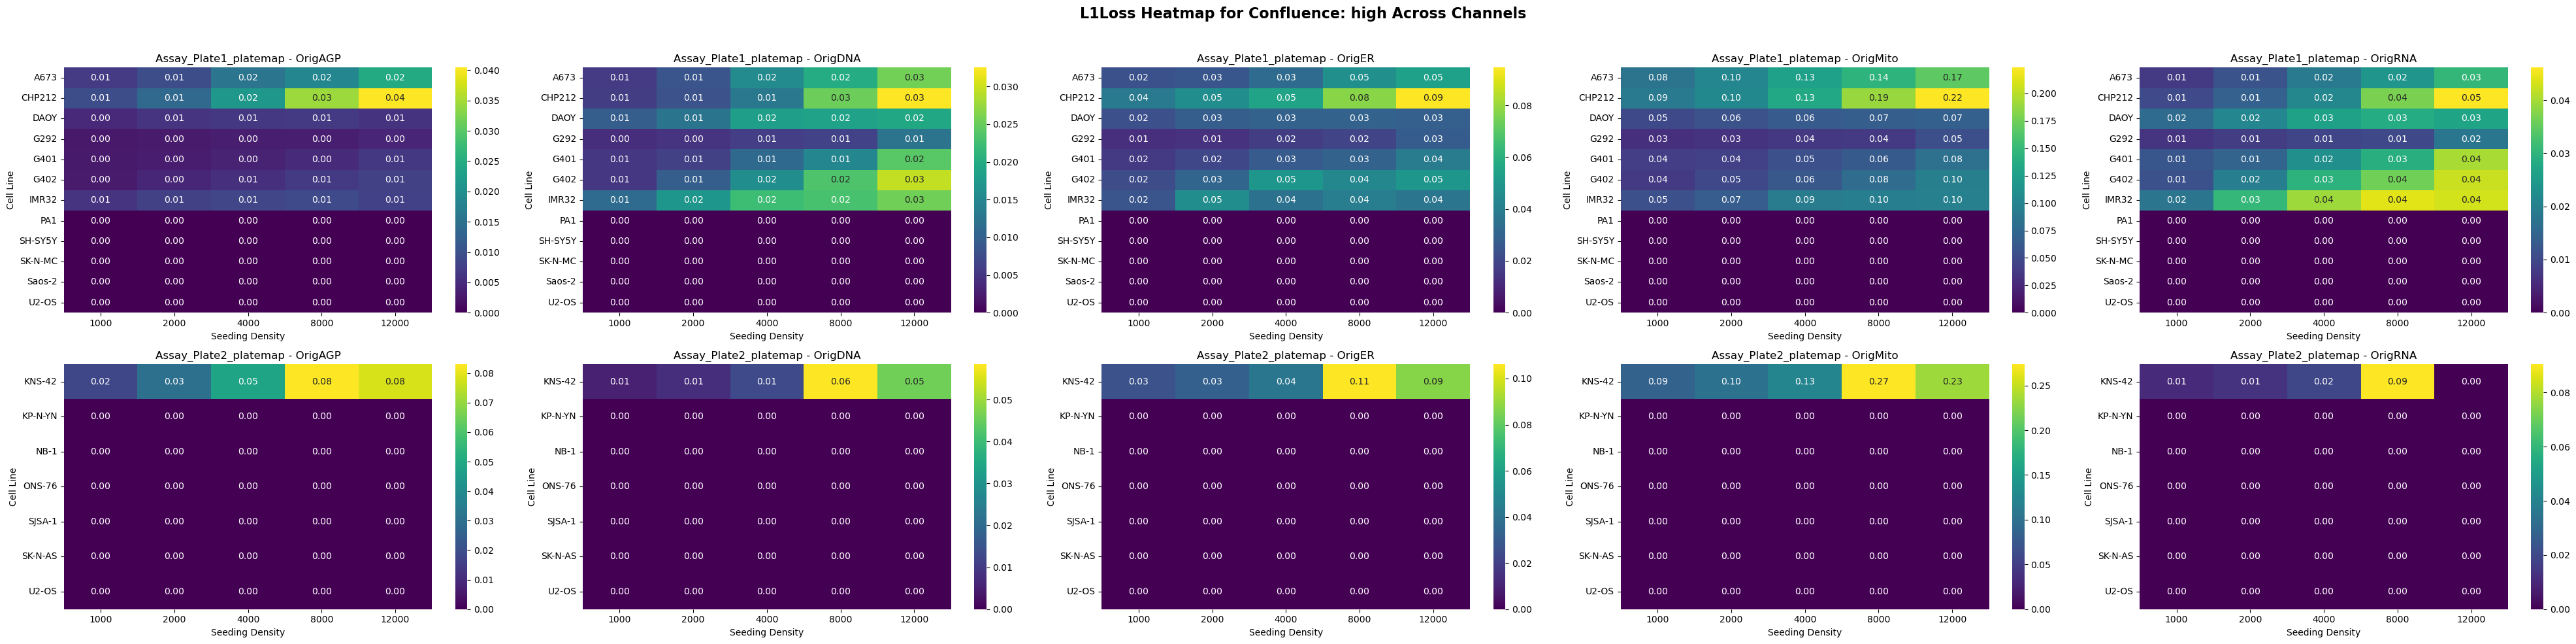

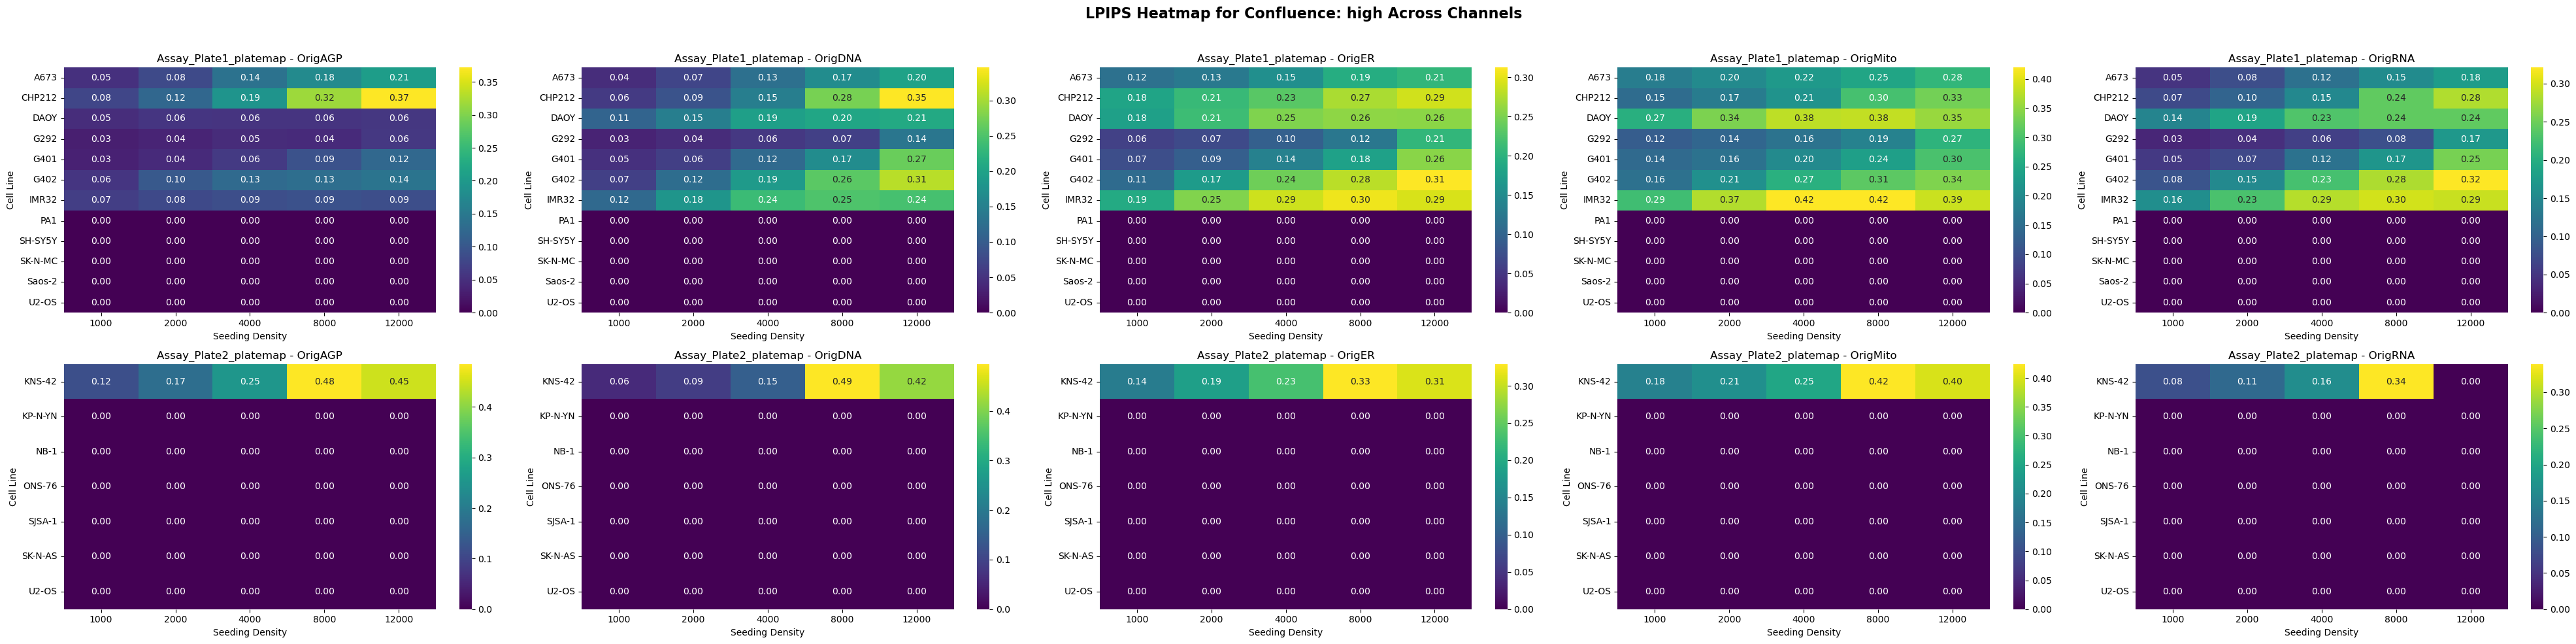

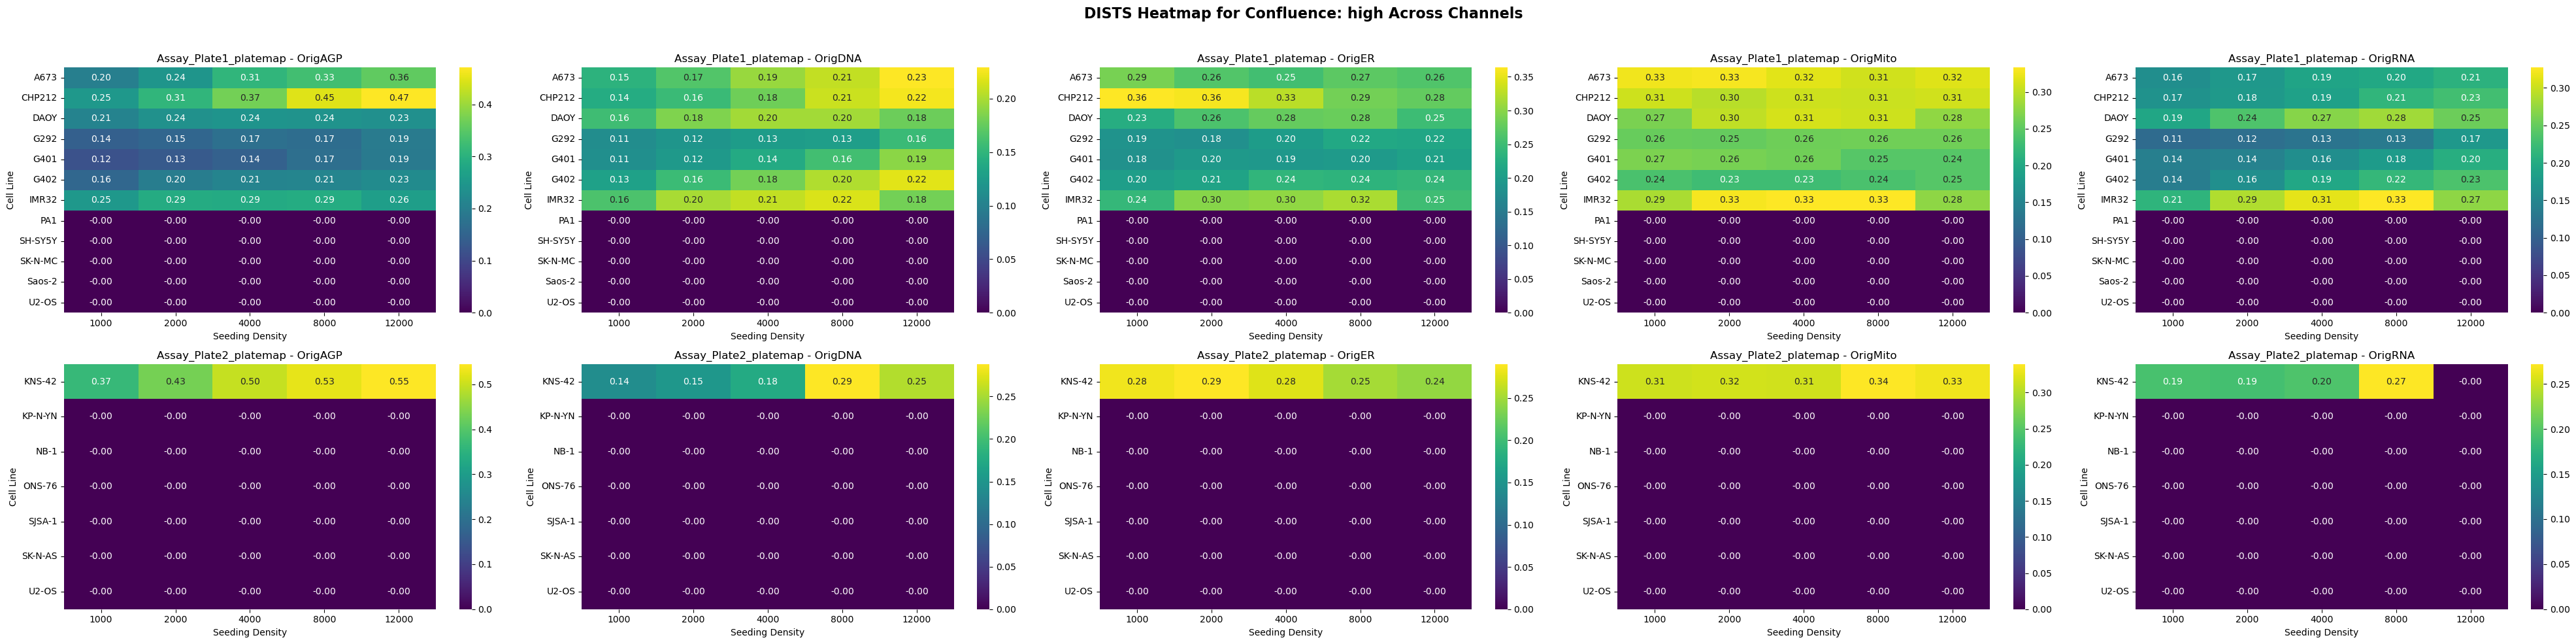

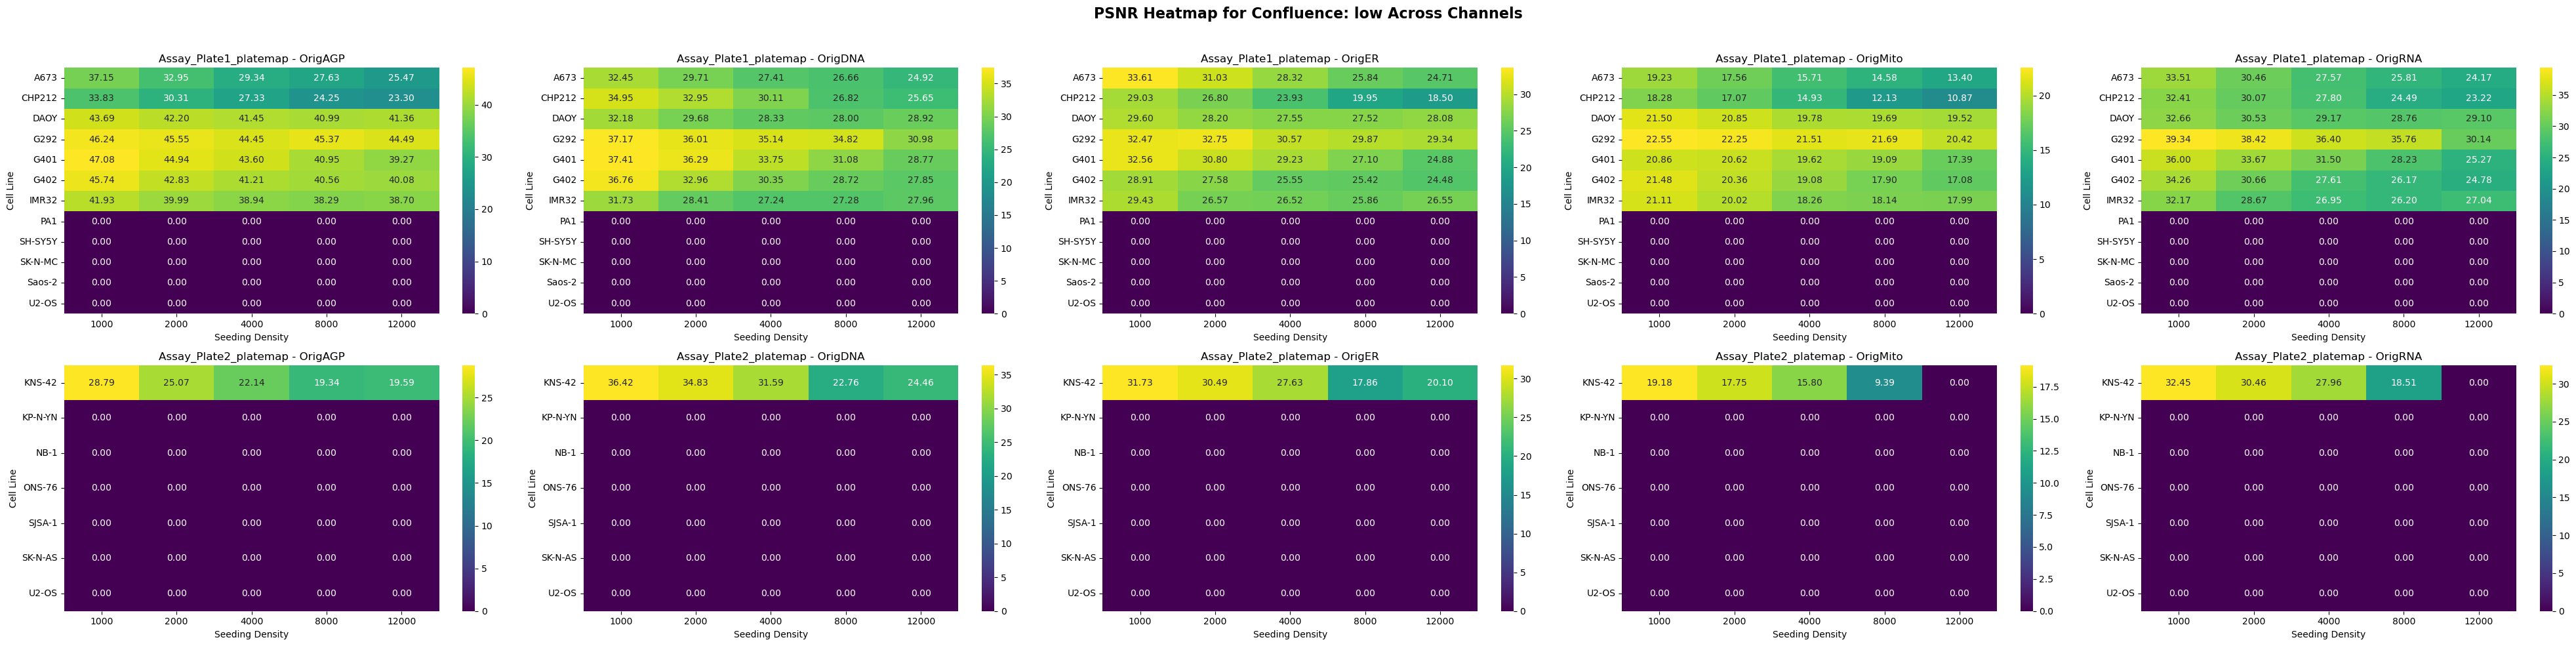

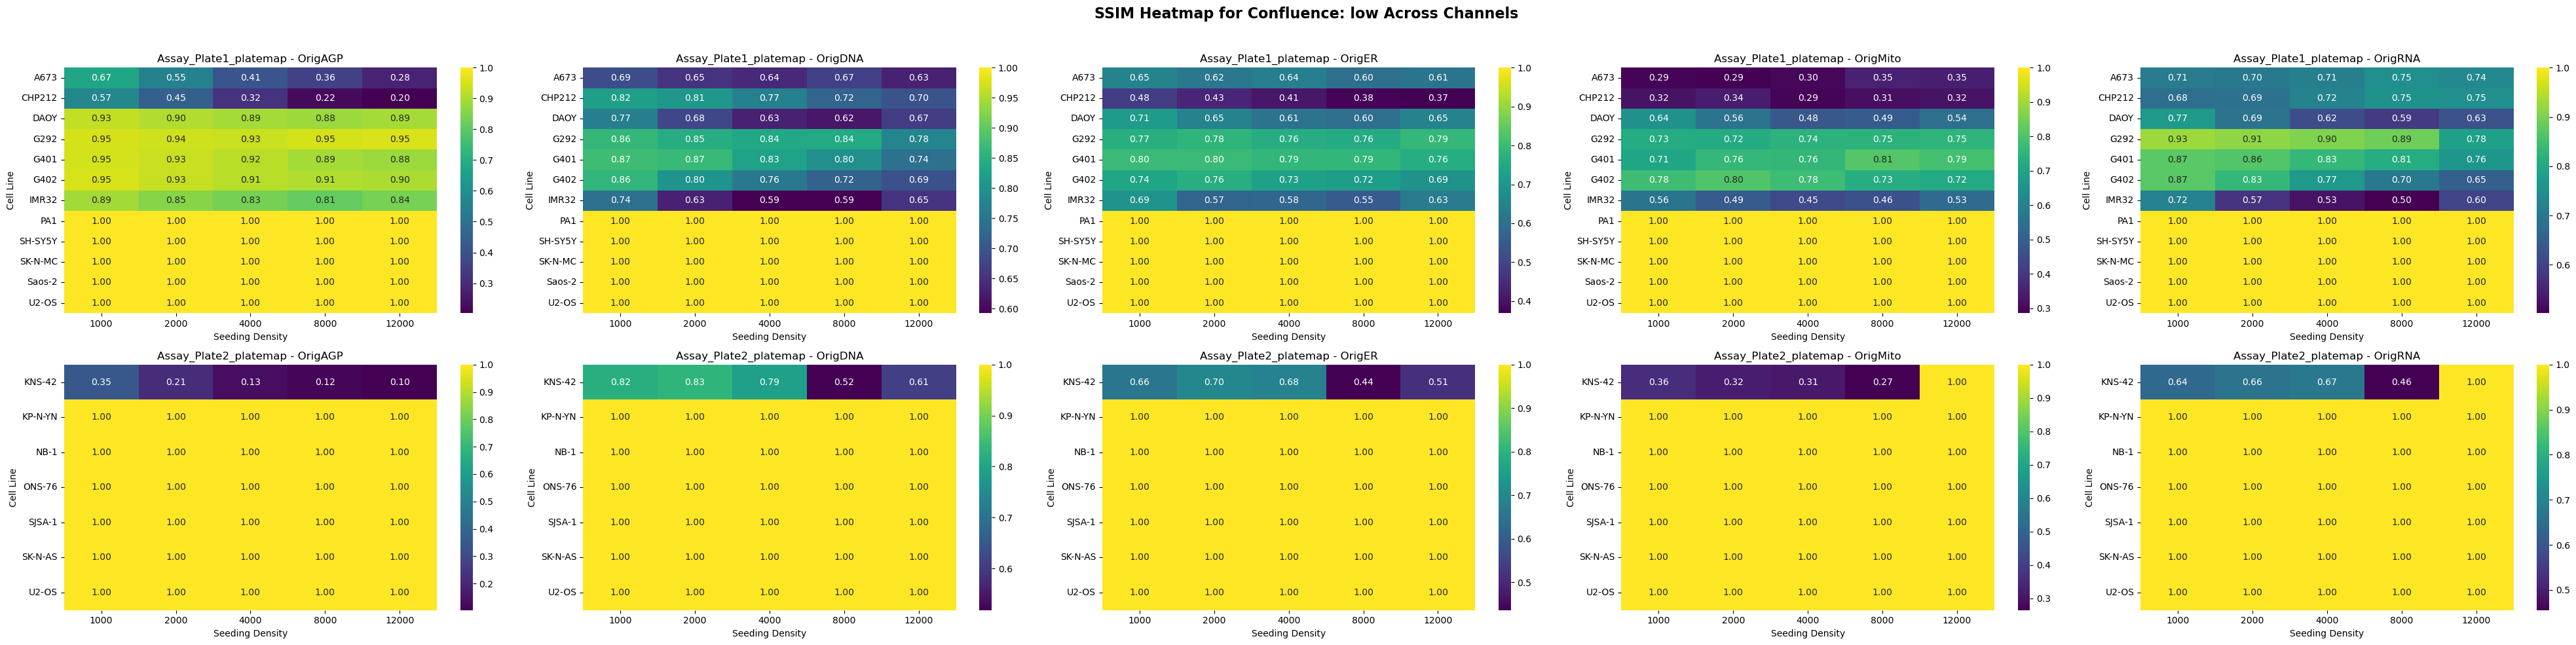

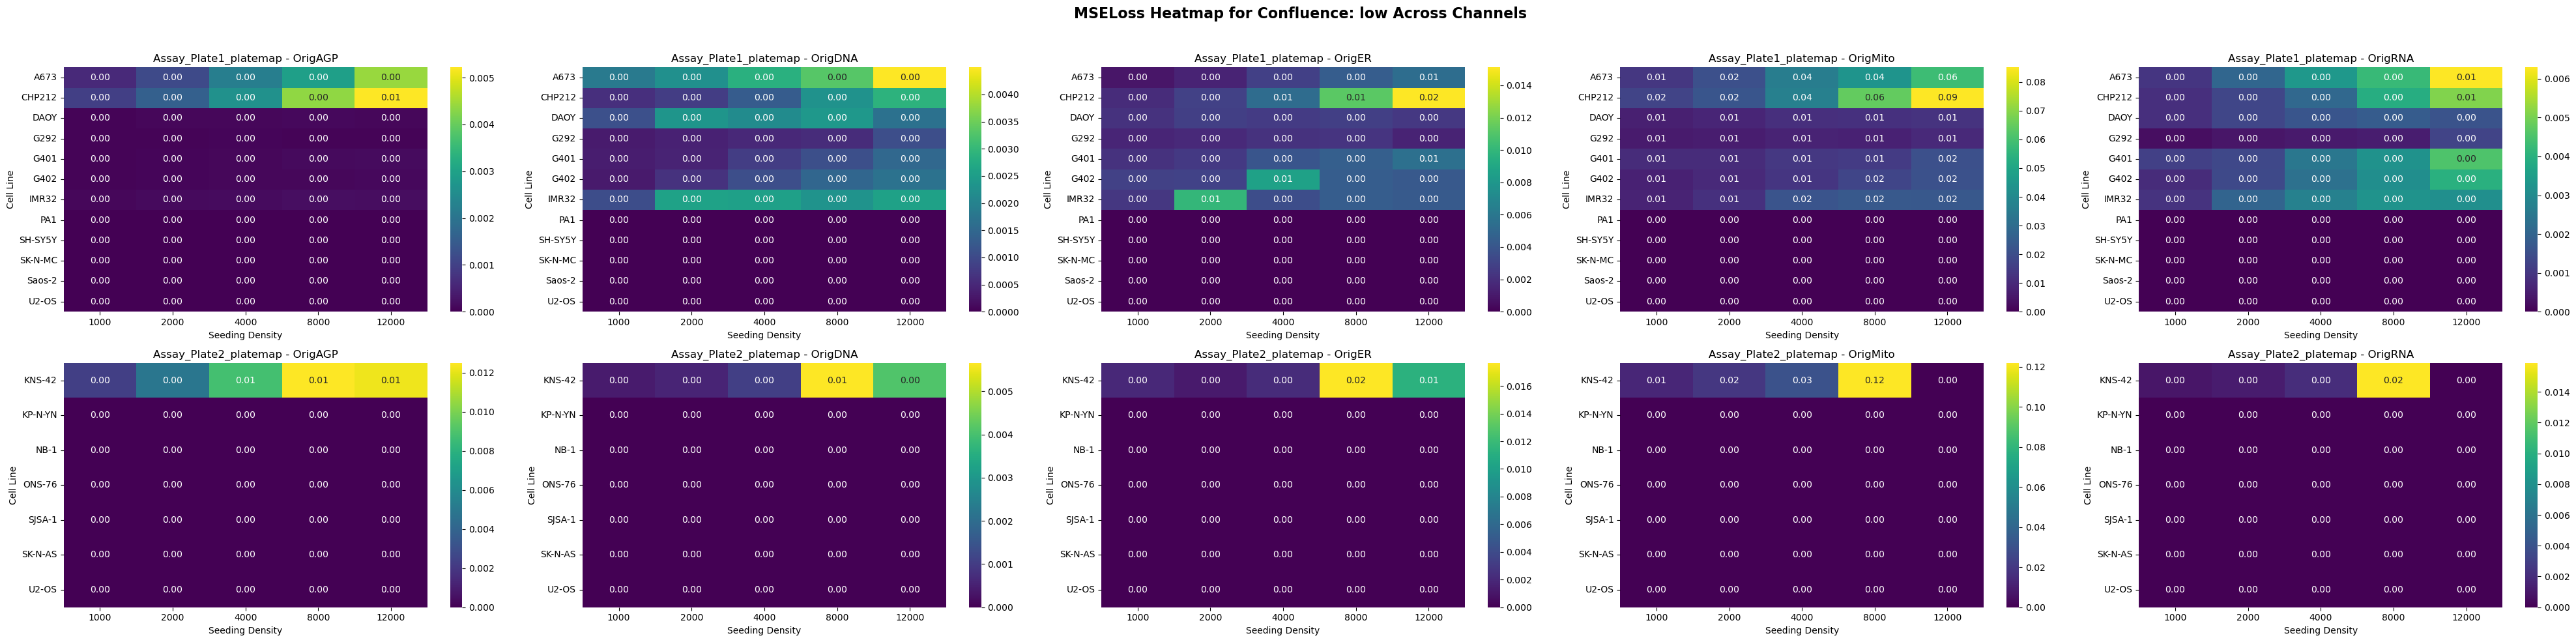

In [ ]:
metrics_columns = [
    metric.__class__.__name__ for metric in  EVAL_METRICS
]

# Group by run_name
grouped = all_metrics_df.groupby('confluence_group')

for confluence_group, group in grouped:
    # Get unique platemap_file and params.channel_name
    unique_platemaps = group['platemap_file'].unique()
    unique_channels = group['params.channel_name'].unique()

    for metric_column in metrics_columns:
    
        # Create a grid of subplots
        fig, axes = plt.subplots(len(unique_platemaps), len(unique_channels), figsize=(40, 10), sharex=False, sharey=False)
        fig.suptitle(f'{metric_column} Heatmap for Confluence: {confluence_group} Across Channels', fontsize=16, fontweight='bold')
        
        for i, platemap in enumerate(unique_platemaps):

            for j, channel in enumerate(unique_channels):
                ax = axes[i, j] if len(unique_platemaps) > 1 and len(unique_channels) > 1 else axes[max(i, j)]
                subset = group[(group['platemap_file'] == platemap) & (group['params.channel_name'] == channel)]
            
                if len(subset) == 0:
                    continue

                heatmap_data = subset.pivot_table(index='cell_line', columns='seeding_density', values=metric_column, aggfunc='mean')
                sns.heatmap(heatmap_data, ax=ax, cmap='viridis', annot=True, fmt=".2f")
                ax.set_title(f'{platemap} - {channel}')
                ax.set_xlabel('Seeding Density')
                ax.set_ylabel('Cell Line')
        
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()